In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Flatten, Input, Concatenate
from tensorflow.keras.models import Model
import sys
import os
import yaml
import matplotlib.pyplot as plt
import scipy

import tensorflow as tf

In [2]:
# This config file hosts the variable names, lists and column identifiers for the nps script
# Variable Names

model_index = 'Name' # Sample ID ['Compound', 'Name']
test_model_index = 'Compound' # The database to predict on 
model_y = 'RT'  #['PTC Confirmed RT', 'Retention Time (min)']
test_model_y = 'PTC Confirmed RT' # The database to predict on
model_X = 'SMILES' # The SMILES String column
# Column Names
lab_column_name = 'Lab'
rdkit_features = ['Molecular Weight', 'LogP', 'Ring Count', 'BalabanJ', 'Chi1', 'Total Negative Charge']

## Filepaths

# Create Dataset
raw_data_dir = 'Data'
output_dir = 'Data'
linking_dir = 'output'
# ML pipeline
default_output_dir = 'output'
model_names = ['Random Forest'] #['CatBoost', 'LGBM', 'Neural Network','Random Forest', 'XGBoost'] 
## Filenames
raw_data_filename = '2024-06-26_X500R_Database_for_Aaron.xlsx'
smiles_dict_filename = 'smiles_dict.pkl'
output_filename = '2024_11_27_X500R_rdkit_only.csv'


# Assume `SMILESVectorizer`, `flatten_and_create_feature_names`, `fit_processor`, etc., exist

# Load Data
data_path = "//kaggle/input/radd-pt2-all-labs/2024_12_10_all_labs_rdkit.csv"
data = pd.read_csv(data_path)

# SMILES Vectorization code

In [3]:
def create_char_to_int(smiles):
    """Create a character-to-integer mapping based on the input SMILES strings."""
    unique_chars = set(''.join(smiles))
    char_to_int = {char: i for i, char in enumerate(unique_chars)}
    char_to_int['!'] = len(char_to_int)  # Start character
    char_to_int['E'] = len(char_to_int)  # End character
    char_to_int['UNK'] = len(char_to_int)  # Unknown character
    return char_to_int
    
class SMILESVectorizer:
    def __init__(self):
        self.char_to_int = None
        self.max_smiles_length = None
        self.charset_size = None

    def fit(self, smiles):
        
        self.char_to_int = self.create_char_to_int(smiles)
        self.max_smiles_length = max([len(smile) for smile in smiles])
        m = [len(smile) for smile in smiles]
        print(f'max_smiles_length: {m}')
        self.charset_size = len(self.char_to_int)
        print(f"Charset Size: {self.charset_size}")
        print(f"Char to Int Mapping: {self.char_to_int}")
        return self

    def transform(self, smiles):
        embed_length = self.max_smiles_length + 2  # Add 2 for start ('!') and end ('E') characters
        one_hot = np.zeros((len(smiles), embed_length, self.charset_size), dtype=np.uint8)
        for i, smile in enumerate(smiles):
            one_hot[i, 0, self.char_to_int["!"]] = 1  # encode start character
            for j, c in enumerate(smile):
                if j + 1 < embed_length - 1:  # ensure within bounds
                    if c in self.char_to_int:
                        one_hot[i, j + 1, self.char_to_int[c]] = 1
                    else:
                        one_hot[i, j + 1, self.char_to_int['UNK']] = 1
            one_hot[i, min(len(smile) + 1, embed_length - 1), self.char_to_int["E"]] = 1  # encode end character
        return one_hot[:, 0:-1, :], one_hot[:, 1:, :]

    def create_char_to_int(self, smiles):
        """
        This can be expanded for multi-character support - consider using str to replace cap strings then small ones
        And then replace with $, ?, %
        """
        char_to_int = {'l': 1, 'y': 2, '@': 3, '3': 4, 'H': 5, 'S': 6, 'F': 7, 'C': 8, 'r': 9, 's': 10, '/': 11, 'c': 12, 'o': 13,
       '+': 14, 'I': 15, '5': 16, '(': 17, '2': 18, ')': 19, '9': 20, 'i': 21, '#': 22, '6': 23, '8': 24, '4': 25, '=': 26,
       '1': 27, 'O': 28, '[': 29, 'D': 30, 'B': 31, ']': 32, 'N': 33, '7': 34, 'n': 35, '-': 36}

        char_to_int["!"] = 0
        char_to_int["E"] = 0
        char_to_int["UNK"] = 0
        return char_to_int
    
def vectorize_smiles(smiles):
    """
    Vectorize a list of SMILES strings into one-hot encoded representations.

    This function converts a list of SMILES strings into a three-dimensional
    one-hot encoded array, suitable for input into neural network models. It
    automatically determines the maximum SMILES length in the dataset and adds
    two additional positions for start ('!') and end ('E') characters.

    Parameters
    ----------
    smiles : list of str
        List of SMILES strings to be vectorized.

    Returns
    -------
    tuple of np.ndarray
        A tuple containing two numpy arrays:
        - The first array is the one-hot encoded input sequences, excluding the end character.
        - The second array is the one-hot encoded output sequences, excluding the start character.
        
    Examples
    --------
    >>> smiles = ["CCO", "NCC", "CCCCCCCCCCC"]
    >>> X, Y = vectorize_smiles(smiles)
    >>> X.shape
    (3, 13, 27)
    >>> Y.shape
    (3, 13, 27)
    Note: for this pipeline Y is a return value we do not utilise.
    """
    char_to_int = create_char_to_int(smiles)

    # Determine the maximum SMILES length
    max_smiles_length = max(len(smile) for smile in smiles)
    embed_length = max_smiles_length + 2  # Add 2 for start ('!') and end ('E') characters
    charset_size = len(char_to_int)
    
    def vectorize(smiles):
        one_hot = np.zeros((len(smiles), embed_length, charset_size), dtype=np.int8)
        for i, smile in enumerate(smiles):
            # encode the start character
            one_hot[i, 0, char_to_int["!"]] = 1
            # encode the rest of the characters
            for j, c in enumerate(smile):
                if c in char_to_int:
                    one_hot[i, j + 1, char_to_int[c]] = 1
                else:
                    one_hot[i, j + 1, char_to_int['UNK']] = 1
            # encode end character
            one_hot[i, len(smile) + 1, char_to_int["E"]] = 1
        # return two, one for input and the other for output
        return one_hot[:, 0:-1, :], one_hot[:, 1:, :]

    return vectorize(smiles)

def flatten_and_create_feature_names(X_vectorized):
    """
    Flatten the 3D one-hot encoded array into a 2D array and create feature names.
    
    Parameters
    ----------
    X_vectorized : np.ndarray
        3D array of shape (samples, max_length, charset_size)
    
    Returns
    -------
    pd.DataFrame
        2D DataFrame with flattened features and meaningful names
    """
    num_samples, max_length, charset_size = X_vectorized.shape
    
    # Flatten the 3D array into a 2D array
    X_flattened = X_vectorized.reshape(num_samples, -1)
    
    # Create feature names
    feature_names = [f"pos_{i}_char_{j}" for i in range(max_length) for j in range(charset_size)]
    
    # Create DataFrame with feature names
    df_flattened = pd.DataFrame(X_flattened, columns=feature_names)
    
    return df_flattened

def combine_with_additional_features(df_flattened, additional_features):
    """
    Combine the flattened DataFrame with additional features.
    
    Parameters
    ----------
    df_flattened : pd.DataFrame
        DataFrame with flattened features
    additional_features : pd.DataFrame
        DataFrame with additional numeric or categorical features
    
    Returns
    -------
    pd.DataFrame
        Combined DataFrame
    """
    combined_df = pd.concat([df_flattened, additional_features], axis=1)
    return combined_df

def preprocess_combined_df(combined_df, output_dir):
    """
    Preprocess the combined DataFrame.
    
    Parameters
    ----------
    combined_df : pd.DataFrame
        Combined DataFrame with flattened SMILES features and additional features    
    Returns
    -------
    np.ndarray
        Preprocessed array
    ColumnTransformer
        Fitted preprocessor
    """
    # Dynamically identify numeric and categorical features
    numeric_features = combined_df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = combined_df.select_dtypes(include=['object']).columns.tolist()
    
    pipe_num = Pipeline([
        ('impute', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())
    ])
    pipe_cat = Pipeline([
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessor = ColumnTransformer([
        ('num', pipe_num, numeric_features),
        ('cat', pipe_cat, categorical_features)
    ], remainder='passthrough')
    
    X_preprocessed = preprocessor.fit_transform(combined_df)
    with open(os.path.join(output_dir, 'processor.pkl'), 'wb') as f:
        pickle.dump(preprocessor, f)
    return X_preprocessed, preprocessor

# Leave one out

In [4]:
# SMILES and Additional Features
maccs_columns = [f"MACCS_{i}" for i in range(1, 167)]

# Drop rows with missing target or features
data.dropna(subset=[model_X, model_y], inplace=True)

labs = data.Lab.unique()
labs

array(['BCCDC', 'Aarhus', nan, 'Academy of Forensic Science', 'Adelaide',
       'Australian Racing Forensic Laboratory', 'ChemCentre',
       'Copenhagen', 'Estonian Forensic Science Institute',
       'Finnish Customs Laboratory', 'Ghent University',
       'IUPA, UJI I (E)', "King's College Hospital", 'LADR',
       'Labor Krone', 'Mainz', 'Odense', 'RCMP-NFLS',
       'San Francisco OCME', 'The University of Queensland', 'Trondheim',
       'University Hospital of Northern Norway', 'University of Athens',
       'Victorian Institute of Forensic Medicine',
       'Zurich Institute of Forensic Medicine', 'SFO', 'CFSRE'],
      dtype=object)

In [5]:
for leftout in labs:
    
    deploy_set = data[ data.Lab == leftout ]
    dev_set    = data[ data.Lab != leftout ]
    print( 'Size of dev set:',dev_set.shape[0], 'Size of deployment set:',deploy_set.shape[0], f'...when {leftout} is left out' )

Size of dev set: 3129 Size of deployment set: 167 ...when BCCDC is left out
Size of dev set: 3073 Size of deployment set: 223 ...when Aarhus is left out
Size of dev set: 3296 Size of deployment set: 0 ...when nan is left out
Size of dev set: 3098 Size of deployment set: 198 ...when Academy of Forensic Science is left out
Size of dev set: 3126 Size of deployment set: 170 ...when Adelaide is left out
Size of dev set: 3201 Size of deployment set: 95 ...when Australian Racing Forensic Laboratory is left out
Size of dev set: 3242 Size of deployment set: 54 ...when ChemCentre is left out
Size of dev set: 3157 Size of deployment set: 139 ...when Copenhagen is left out
Size of dev set: 3259 Size of deployment set: 37 ...when Estonian Forensic Science Institute is left out
Size of dev set: 3258 Size of deployment set: 38 ...when Finnish Customs Laboratory is left out
Size of dev set: 3281 Size of deployment set: 15 ...when Ghent University is left out
Size of dev set: 3259 Size of deployment se

max_smiles_length: [42, 51, 40, 44, 41, 31, 48, 29, 51, 40, 27, 45, 26, 42, 26, 47, 26, 22, 29, 44, 28, 51, 43, 44, 41, 48, 16, 25, 43, 49, 38, 27, 42, 23, 31, 23, 43, 40, 40, 23, 23, 17, 35, 33, 36, 43, 54, 37, 44, 36, 31, 27, 40, 26, 48, 31, 45, 40, 31, 46, 34, 45, 36, 38, 38, 47, 28, 66, 28, 23, 40, 39, 28, 33, 29, 37, 15, 40, 37, 47, 54, 37, 20, 43, 43, 47, 36, 53, 30, 48, 43, 42, 33, 42, 41, 37, 32, 30, 42, 48, 47, 21, 29, 40, 30, 33, 54, 41, 26, 49, 42, 42, 29, 41, 41, 51, 25, 46, 49, 42, 18, 48, 23, 25, 31, 42, 21, 44, 19, 57, 35, 43, 45, 48, 38, 49, 47, 29, 48, 26, 26, 43, 40, 36, 35, 36, 30, 16, 30, 22, 71, 40, 14, 43, 36, 56, 49, 29, 25, 47, 41, 36, 43, 41, 16, 42, 38, 41, 44, 55, 40, 30, 27, 42, 30, 28, 58, 38, 27, 34, 35, 28, 29, 36, 48, 34, 24, 30, 21, 33, 31, 57, 47, 48, 45, 42, 44, 49, 50, 43, 32, 44, 48, 30, 20, 72, 34, 26, 36, 36, 45, 19, 49, 41, 29, 37, 43, 26, 37, 38, 32, 33, 27, 44, 44, 37, 33, 44, 21, 53, 43, 48, 27, 44, 39, 41, 37, 30, 47, 46, 41, 31, 45, 47, 34, 

I0000 00:00:1734548427.555736      88 service.cc:145] XLA service 0x7f2e2c001fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734548427.555786      88 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 3/40 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 49.7649 - mae: 6.0895

I0000 00:00:1734548431.569928      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - loss: 23.7725 - mae: 3.6815 - val_loss: 6.5460 - val_mae: 1.7214
Epoch 2/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 5.8051 - mae: 1.6705 - val_loss: 5.5626 - val_mae: 1.6599
Epoch 3/500
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 4.4100 - mae: 1.4039 - val_loss: 6.3510 - val_mae: 1.9276
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 6.3411 - mae: 1.9570
Test Loss: 6.351010322570801, Test MAE: 1.927614450454712
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


/tmp/ipykernel_23/3094868229.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_set['prediction_errs'] = errs


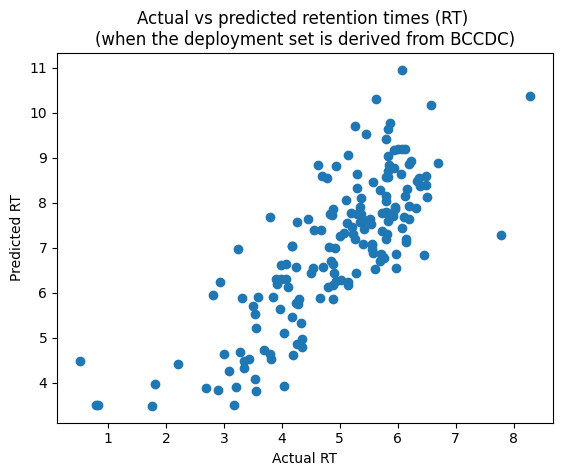

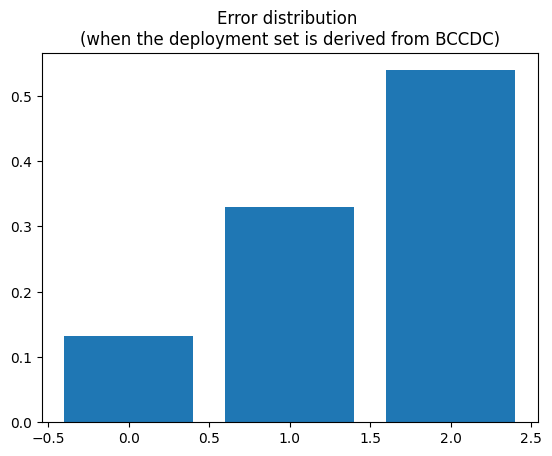

In [6]:
for leftout in [labs[0]]:
    try:
        deploy_set = data[ data.Lab == leftout ]
        dev_set    = data[ data.Lab != leftout ]
        
        # Split the data
        X = dev_set[[model_X] + rdkit_features + maccs_columns]
        y = dev_set[model_y]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        deploy_X = deploy_set[[model_X] + rdkit_features + maccs_columns]
        deploy_y = deploy_set[model_y]
            
        # SMILES Encoding
        vectorizer = SMILESVectorizer()
        
        def get_inputs(X_train, X_test, deploy_X):
            vectorizer.fit(X_train[model_X].tolist())
        
            X_train_smiles, _ = vectorizer.transform(X_train[model_X].tolist())
            X_test_smiles, _ = vectorizer.transform(X_test[model_X].tolist())
        
            deploy_X_test_smiles, _ = vectorizer.transform(deploy_X[model_X].tolist())
                
            
            # Flatten and Reshape for 1D CNN
            X_train_smiles = np.array([np.array(x).flatten() for x in X_train_smiles])
            X_test_smiles = np.array([np.array(x).flatten() for x in X_test_smiles])
            deploy_X_test_smiles = np.array([np.array(x).flatten() for x in deploy_X_test_smiles])
        
            X_train_smiles = X_train_smiles.reshape((X_train_smiles.shape[0], X_train_smiles.shape[1], 1))
            X_test_smiles = X_test_smiles.reshape((X_test_smiles.shape[0], X_test_smiles.shape[1], 1))
            deploy_X_test_smiles = deploy_X_test_smiles.reshape((deploy_X_test_smiles.shape[0], deploy_X_test_smiles.shape[1], 1))
        
            # Preprocess Additional Features
            scaler = StandardScaler()
            X_train_additional = scaler.fit_transform(X_train[rdkit_features + maccs_columns])
            X_test_additional = scaler.transform(X_test[rdkit_features + maccs_columns])
            deploy_X_test_additional = scaler.transform(deploy_X[rdkit_features + maccs_columns])
        
            return X_train_smiles, X_test_smiles, deploy_X_test_smiles, X_train_additional, X_test_additional, deploy_X_test_additional
        
        X_train_smiles, X_test_smiles, deploy_X_test_smiles, X_train_additional, X_test_additional, deploy_X_test_additional = get_inputs(X_train, X_test, deploy_X)
            
        def get_model( MID=1 ):
            if MID==1:
                # Model 1
                # SMILES Input
                input_smiles = Input(shape=(X_train_smiles.shape[1], 1), name='SMILES_Input')
                x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_smiles)
                x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
                x = Flatten()(x)
                
                # Additional Features Input
                input_additional = Input(shape=(X_train_additional.shape[1],), name='Additional_Features_Input')
                y = Dense(64, activation='relu')(input_additional)
                
                # Combine
                combined = Concatenate()([x, y])
                z = Dense(128, activation='relu')(combined)
                z = Dense(64, activation='relu')(z)
                output = Dense(1)(z)
                
            # Compile Model (Implement Early Stopping)
            model = Model(inputs=[input_smiles, input_additional], outputs=output)
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            return model 
    
        MID=1
        
        model = get_model(MID)
        
        
        earlystop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=0,
            verbose=0,
            mode='auto',
            baseline=None,
            restore_best_weights=False,
            start_from_epoch=0)
        callbacks = [earlystop]
    
        BS = 64 
        trial_str = f'{MID}_BS{BS}_'
        
        # Train Model
        history = model.fit(
            [X_train_smiles, X_train_additional], y_train,
            validation_data=([X_test_smiles, X_test_additional], y_test),
            epochs=500, batch_size=BS, callbacks=callbacks
        )
        
        # Evaluate
        test_loss, test_mae = model.evaluate([X_test_smiles, X_test_additional], y_test)
        print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")
    
        
        deploy_out = model.predict( [deploy_X_test_smiles, deploy_X_test_additional] ) .squeeze()
        
        title= f'Actual vs predicted retention times (RT) \n(when the deployment set is derived from {leftout})'
        
        plt.figure()    
        plt.scatter( deploy_y, deploy_out )
        plt.xlabel( 'Actual RT'); plt.ylabel('Predicted RT')
        plt.title( title )
        
        errs  = deploy_out - deploy_y    
        deploy_set['prediction_errs'] = errs     
    
        leftout_str = leftout.replace(' ','_')
    
        c0=errs[ ( errs <= 1 )].shape[0]
        c1=errs[ ( errs > 1 )&(errs<=2)].shape [0]
        c2=errs[ ( errs > 2 )].shape [0]
    
        title= f'Error distribution \n(when the deployment set is derived from {leftout})'
        
        plt.figure()
        plt.bar( [0,1,2], np.array([c0,c1,c2])/ len(errs) )
        plt.title(title)
    
        # save key results    
        plt.savefig(f'{MID}_{leftout_str}_{trial_str}_errplot.png')
        model.save(f'{MID}_{leftout}_{trial_str}.h5')
        deploy_set['prediction_errs'].to_csv(f'{MID}_{leftout_str}_{trial_str}_errs.csv')
    except Exception as e:
        print(e)

In [ ]:
for leftout in labs[1:]:
    try:
        deploy_set = data[ data.Lab == leftout ]
        dev_set    = data[ data.Lab != leftout ]
        
        # Split the data
        X = dev_set[[model_X] + rdkit_features + maccs_columns]
        y = dev_set[model_y]
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        deploy_X = deploy_set[[model_X] + rdkit_features + maccs_columns]
        deploy_y = deploy_set[model_y]
            
        # SMILES Encoding
        vectorizer = SMILESVectorizer()
        
        def get_inputs(X_train, X_test, deploy_X):
            vectorizer.fit(X_train[model_X].tolist())
        
            X_train_smiles, _ = vectorizer.transform(X_train[model_X].tolist())
            X_test_smiles, _ = vectorizer.transform(X_test[model_X].tolist())
        
            deploy_X_test_smiles, _ = vectorizer.transform(deploy_X[model_X].tolist())
                
            
            # Flatten and Reshape for 1D CNN
            X_train_smiles = np.array([np.array(x).flatten() for x in X_train_smiles])
            X_test_smiles = np.array([np.array(x).flatten() for x in X_test_smiles])
            deploy_X_test_smiles = np.array([np.array(x).flatten() for x in deploy_X_test_smiles])
        
            X_train_smiles = X_train_smiles.reshape((X_train_smiles.shape[0], X_train_smiles.shape[1], 1))
            X_test_smiles = X_test_smiles.reshape((X_test_smiles.shape[0], X_test_smiles.shape[1], 1))
            deploy_X_test_smiles = deploy_X_test_smiles.reshape((deploy_X_test_smiles.shape[0], deploy_X_test_smiles.shape[1], 1))
        
            # Preprocess Additional Features
            scaler = StandardScaler()
            X_train_additional = scaler.fit_transform(X_train[rdkit_features + maccs_columns])
            X_test_additional = scaler.transform(X_test[rdkit_features + maccs_columns])
            deploy_X_test_additional = scaler.transform(deploy_X[rdkit_features + maccs_columns])
        
            return X_train_smiles, X_test_smiles, deploy_X_test_smiles, X_train_additional, X_test_additional, deploy_X_test_additional
        
        X_train_smiles, X_test_smiles, deploy_X_test_smiles, X_train_additional, X_test_additional, deploy_X_test_additional = get_inputs(X_train, X_test, deploy_X)
            
        def get_model( MID=1 ):
            if MID==1:
                # Model 1
                # SMILES Input
                input_smiles = Input(shape=(X_train_smiles.shape[1], 1), name='SMILES_Input')
                x = Conv1D(filters=64, kernel_size=3, activation='relu')(input_smiles)
                x = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
                x = Flatten()(x)
                
                # Additional Features Input
                input_additional = Input(shape=(X_train_additional.shape[1],), name='Additional_Features_Input')
                y = Dense(64, activation='relu')(input_additional)
                
                # Combine
                combined = Concatenate()([x, y])
                z = Dense(128, activation='relu')(combined)
                z = Dense(64, activation='relu')(z)
                output = Dense(1)(z)
                
            # Compile Model (Implement Early Stopping)
            model = Model(inputs=[input_smiles, input_additional], outputs=output)
            model.compile(optimizer='adam', loss='mse', metrics=['mae'])
            return model 
    
        MID=1
        
        model = get_model(MID)
        
        
        earlystop = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=0,
            verbose=0,
            mode='auto',
            baseline=None,
            restore_best_weights=False,
            start_from_epoch=0)
        callbacks = [earlystop]
    
        BS = 64 
        trial_str = f'{MID}_BS{BS}_'
        
        # Train Model
        history = model.fit(
            [X_train_smiles, X_train_additional], y_train,
            validation_data=([X_test_smiles, X_test_additional], y_test),
            epochs=500, batch_size=BS, callbacks=callbacks
        )
        
        # Evaluate
        test_loss, test_mae = model.evaluate([X_test_smiles, X_test_additional], y_test)
        print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")
    
        
        deploy_out = model.predict( [deploy_X_test_smiles, deploy_X_test_additional] ) .squeeze()
        
        title= f'Actual vs predicted retention times (RT) \n(when the deployment set is derived from {leftout})'
        
        plt.figure()    
        plt.scatter( deploy_y, deploy_out )
        plt.xlabel( 'Actual RT'); plt.ylabel('Predicted RT')
        plt.title( title )
        
        errs  = deploy_out - deploy_y    
        deploy_set['prediction_errs'] = errs     
    
        leftout_str = leftout.replace(' ','_')
    
        c0=errs[ ( errs <= 1 )].shape[0]
        c1=errs[ ( errs > 1 )&(errs<=2)].shape [0]
        c2=errs[ ( errs > 2 )].shape [0]
    
        title= f'Error distribution \n(when the deployment set is derived from {leftout})'
        
        plt.figure()
        plt.bar( [0,1,2], np.array([c0,c1,c2])/ len(errs) )
        plt.title(title)
    
        # save key results    
        plt.savefig(f'{MID}_{leftout_str}_{trial_str}_errplot.png')
        model.save(f'{MID}_{leftout}_{trial_str}.h5')
        deploy_set['prediction_errs'].to_csv(f'{MID}_{leftout_str}_{trial_str}_errs.csv')
    except Exception as e:
        print(e)

max_smiles_length: [45, 44, 26, 18, 42, 47, 34, 20, 18, 33, 51, 37, 32, 43, 41, 38, 23, 43, 43, 46, 30, 36, 42, 17, 23, 31, 40, 33, 31, 29, 36, 27, 40, 30, 30, 27, 20, 28, 44, 47, 27, 45, 44, 45, 38, 21, 26, 34, 42, 22, 24, 37, 42, 27, 37, 43, 40, 36, 21, 29, 41, 39, 27, 39, 35, 50, 55, 27, 36, 40, 51, 34, 16, 45, 36, 48, 39, 32, 37, 42, 35, 46, 39, 44, 18, 41, 48, 43, 24, 28, 39, 42, 45, 40, 42, 20, 41, 18, 26, 15, 29, 34, 44, 55, 40, 24, 17, 32, 37, 22, 37, 43, 44, 30, 49, 39, 48, 46, 44, 36, 39, 23, 27, 44, 61, 18, 37, 30, 27, 35, 43, 43, 31, 30, 28, 39, 14, 50, 39, 24, 28, 23, 44, 24, 41, 25, 25, 23, 43, 31, 33, 42, 28, 35, 30, 42, 49, 28, 40, 23, 47, 11, 30, 37, 43, 39, 47, 51, 33, 20, 29, 44, 28, 32, 19, 49, 23, 56, 48, 35, 46, 47, 48, 50, 58, 40, 37, 42, 48, 27, 41, 54, 29, 26, 19, 28, 42, 26, 40, 37, 37, 24, 37, 63, 25, 23, 31, 25, 47, 26, 49, 49, 43, 43, 19, 38, 44, 48, 31, 54, 40, 35, 46, 47, 43, 23, 47, 44, 45, 30, 32, 30, 53, 45, 47, 45, 27, 49, 43, 17, 35, 26, 43, 38, 37, 

/tmp/ipykernel_23/428768729.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_set['prediction_errs'] = errs


max_smiles_length: [40, 26, 27, 40, 31, 44, 33, 26, 46, 50, 23, 17, 35, 32, 47, 32, 26, 43, 29, 34, 50, 31, 50, 42, 42, 25, 33, 44, 23, 38, 34, 26, 21, 51, 28, 30, 43, 50, 26, 20, 20, 25, 47, 39, 32, 31, 20, 38, 39, 34, 30, 25, 27, 22, 22, 49, 36, 31, 37, 43, 22, 42, 52, 30, 31, 47, 42, 25, 39, 41, 23, 34, 32, 25, 28, 55, 43, 36, 52, 31, 29, 30, 28, 44, 26, 42, 27, 25, 33, 36, 29, 42, 39, 28, 14, 23, 27, 42, 23, 54, 30, 29, 20, 40, 23, 44, 32, 32, 40, 46, 48, 31, 29, 40, 20, 46, 59, 27, 43, 56, 24, 51, 40, 38, 47, 19, 32, 47, 63, 52, 45, 51, 22, 47, 37, 21, 45, 44, 38, 41, 46, 34, 37, 36, 24, 41, 42, 24, 42, 39, 48, 40, 35, 43, 43, 44, 25, 25, 39, 22, 18, 30, 51, 29, 44, 27, 41, 27, 45, 29, 52, 24, 24, 46, 47, 40, 35, 37, 40, 39, 46, 30, 48, 51, 34, 20, 44, 32, 26, 18, 42, 23, 62, 39, 48, 22, 43, 36, 21, 26, 43, 35, 23, 27, 28, 38, 33, 41, 66, 30, 36, 38, 16, 52, 27, 43, 64, 41, 37, 20, 44, 40, 41, 17, 23, 28, 23, 27, 57, 12, 30, 30, 42, 35, 23, 20, 24, 43, 47, 30, 28, 26, 27, 20, 34, 

/tmp/ipykernel_23/428768729.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_set['prediction_errs'] = errs


max_smiles_length: [20, 46, 40, 41, 20, 29, 28, 48, 32, 32, 40, 42, 17, 39, 29, 35, 27, 29, 21, 37, 52, 43, 26, 51, 63, 40, 44, 24, 38, 23, 45, 28, 49, 45, 23, 46, 34, 43, 57, 23, 26, 39, 24, 37, 27, 22, 30, 44, 36, 44, 32, 25, 15, 24, 29, 30, 51, 29, 44, 38, 29, 42, 46, 40, 52, 43, 36, 28, 36, 34, 39, 33, 40, 40, 31, 47, 48, 51, 36, 26, 44, 32, 39, 22, 36, 47, 26, 51, 48, 47, 25, 32, 28, 41, 37, 42, 19, 36, 27, 42, 33, 23, 26, 41, 27, 44, 24, 26, 35, 26, 22, 41, 30, 23, 30, 44, 23, 46, 46, 47, 38, 32, 45, 38, 37, 46, 19, 43, 39, 48, 43, 45, 46, 40, 36, 43, 22, 48, 48, 41, 23, 44, 22, 46, 40, 45, 40, 43, 31, 40, 40, 33, 39, 51, 51, 49, 42, 46, 27, 44, 29, 30, 39, 45, 49, 38, 40, 56, 55, 44, 50, 49, 46, 30, 17, 39, 38, 22, 23, 35, 43, 37, 22, 48, 40, 44, 47, 21, 42, 28, 20, 27, 33, 38, 41, 40, 29, 41, 37, 39, 28, 32, 30, 51, 35, 34, 26, 47, 46, 47, 43, 26, 43, 45, 23, 49, 48, 47, 29, 18, 33, 27, 39, 44, 37, 26, 39, 41, 46, 48, 42, 35, 56, 39, 28, 42, 46, 40, 28, 44, 32, 38, 29, 23, 57, 

/tmp/ipykernel_23/428768729.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_set['prediction_errs'] = errs


max_smiles_length: [42, 52, 29, 30, 23, 37, 32, 39, 46, 37, 43, 31, 36, 20, 34, 43, 28, 28, 30, 30, 43, 41, 36, 39, 30, 18, 29, 42, 40, 37, 32, 14, 32, 51, 38, 19, 49, 30, 31, 39, 32, 32, 40, 40, 23, 32, 29, 48, 22, 23, 43, 62, 22, 46, 31, 42, 38, 42, 63, 44, 34, 51, 40, 35, 41, 32, 36, 27, 39, 46, 34, 26, 41, 39, 22, 41, 24, 19, 33, 38, 35, 54, 34, 44, 46, 25, 48, 33, 18, 30, 51, 23, 44, 37, 41, 15, 23, 33, 52, 23, 24, 23, 23, 11, 46, 26, 40, 39, 48, 47, 48, 19, 44, 26, 26, 32, 23, 33, 39, 22, 53, 49, 26, 30, 40, 58, 45, 47, 45, 39, 34, 28, 30, 36, 19, 35, 37, 42, 27, 44, 43, 37, 20, 44, 21, 28, 38, 28, 43, 27, 33, 30, 46, 40, 39, 44, 22, 38, 44, 43, 47, 37, 24, 23, 47, 42, 30, 47, 18, 39, 48, 42, 45, 40, 20, 44, 42, 24, 41, 41, 26, 51, 39, 50, 46, 24, 45, 48, 27, 53, 25, 20, 33, 41, 42, 51, 24, 47, 53, 48, 47, 51, 30, 39, 42, 31, 49, 40, 43, 40, 53, 43, 43, 30, 51, 46, 41, 29, 41, 30, 25, 44, 38, 42, 31, 23, 41, 49, 44, 47, 15, 25, 40, 35, 27, 30, 30, 43, 34, 51, 50, 26, 47, 28, 39, 

/tmp/ipykernel_23/428768729.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_set['prediction_errs'] = errs


max_smiles_length: [46, 40, 45, 36, 45, 18, 42, 28, 30, 28, 17, 71, 38, 20, 45, 47, 34, 32, 19, 42, 22, 30, 27, 51, 49, 36, 31, 61, 22, 23, 42, 52, 24, 28, 31, 50, 41, 39, 24, 30, 42, 35, 43, 28, 37, 55, 34, 46, 46, 19, 30, 42, 37, 18, 42, 34, 33, 43, 53, 29, 42, 39, 23, 14, 26, 19, 40, 31, 42, 50, 37, 30, 46, 41, 32, 32, 40, 44, 40, 30, 29, 21, 43, 29, 25, 43, 36, 27, 44, 37, 44, 43, 38, 63, 42, 27, 51, 43, 52, 42, 72, 37, 27, 14, 46, 34, 52, 36, 24, 35, 39, 24, 29, 44, 36, 35, 42, 32, 44, 50, 25, 45, 32, 18, 30, 51, 42, 44, 30, 39, 43, 18, 30, 52, 27, 37, 36, 47, 40, 33, 31, 40, 23, 54, 41, 48, 30, 36, 37, 40, 32, 30, 37, 42, 27, 18, 39, 41, 22, 46, 26, 26, 29, 53, 49, 39, 22, 15, 30, 48, 35, 43, 36, 46, 24, 32, 39, 29, 42, 51, 44, 20, 44, 13, 17, 29, 42, 30, 18, 54, 29, 19, 48, 32, 44, 40, 46, 26, 34, 39, 47, 34, 21, 56, 24, 23, 41, 48, 33, 39, 48, 50, 45, 46, 23, 25, 15, 38, 24, 43, 35, 25, 21, 43, 43, 46, 24, 45, 48, 38, 26, 44, 39, 33, 27, 40, 51, 53, 38, 38, 31, 30, 26, 44, 39, 

/tmp/ipykernel_23/428768729.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_set['prediction_errs'] = errs


max_smiles_length: [37, 40, 45, 47, 54, 40, 39, 29, 49, 29, 42, 32, 42, 30, 41, 39, 22, 41, 47, 33, 28, 26, 32, 32, 40, 40, 38, 45, 29, 24, 44, 43, 43, 40, 51, 23, 49, 38, 44, 63, 43, 44, 37, 35, 44, 47, 47, 45, 29, 27, 46, 34, 53, 23, 29, 39, 41, 24, 35, 41, 19, 35, 46, 35, 44, 20, 25, 41, 35, 18, 30, 51, 35, 44, 40, 38, 29, 49, 40, 52, 30, 48, 27, 31, 49, 34, 46, 40, 15, 29, 29, 48, 28, 33, 44, 47, 32, 19, 44, 39, 22, 50, 43, 26, 24, 46, 25, 33, 19, 20, 45, 36, 41, 40, 36, 22, 42, 33, 21, 46, 44, 32, 38, 20, 44, 45, 37, 28, 57, 42, 34, 21, 31, 37, 51, 42, 39, 18, 53, 47, 31, 46, 30, 21, 43, 28, 54, 23, 39, 48, 22, 45, 40, 48, 31, 40, 24, 45, 28, 29, 44, 47, 34, 46, 24, 45, 45, 37, 41, 20, 55, 33, 22, 40, 51, 20, 42, 46, 22, 28, 36, 36, 39, 51, 49, 47, 40, 30, 44, 56, 41, 54, 46, 48, 26, 47, 37, 50, 37, 48, 28, 28, 43, 50, 37, 44, 47, 20, 19, 22, 31, 27, 38, 23, 36, 42, 19, 57, 46, 45, 28, 25, 47, 34, 49, 24, 26, 23, 44, 47, 26, 43, 42, 24, 41, 48, 26, 47, 46, 31, 30, 43, 40, 33, 42, 

/tmp/ipykernel_23/428768729.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_set['prediction_errs'] = errs


max_smiles_length: [51, 25, 26, 38, 36, 42, 21, 43, 28, 30, 45, 40, 44, 38, 20, 28, 47, 34, 32, 28, 25, 51, 20, 27, 27, 49, 36, 31, 41, 25, 44, 42, 52, 32, 42, 41, 42, 23, 39, 24, 44, 33, 28, 32, 32, 14, 20, 36, 51, 39, 54, 30, 17, 40, 30, 32, 50, 41, 24, 26, 29, 42, 45, 56, 14, 54, 23, 42, 27, 34, 25, 46, 41, 27, 39, 32, 32, 40, 44, 31, 51, 29, 39, 46, 46, 26, 43, 52, 25, 45, 35, 51, 33, 30, 63, 49, 32, 46, 25, 41, 28, 37, 25, 43, 43, 46, 34, 41, 36, 23, 45, 32, 24, 40, 43, 42, 35, 47, 31, 44, 27, 25, 37, 15, 18, 30, 51, 36, 44, 37, 22, 34, 44, 27, 52, 21, 39, 29, 29, 33, 26, 24, 40, 47, 43, 44, 48, 42, 40, 23, 45, 32, 36, 45, 42, 26, 28, 39, 42, 22, 38, 50, 26, 49, 52, 51, 29, 35, 13, 33, 40, 65, 51, 36, 26, 41, 40, 41, 19, 52, 44, 42, 20, 44, 32, 24, 43, 33, 41, 44, 23, 28, 24, 47, 47, 33, 30, 43, 24, 44, 43, 47, 43, 42, 37, 48, 43, 42, 30, 44, 39, 48, 19, 45, 49, 21, 62, 30, 30, 24, 39, 37, 47, 31, 36, 41, 46, 24, 45, 41, 35, 71, 45, 51, 33, 49, 46, 51, 50, 43, 39, 30, 49, 43, 44, 

/tmp/ipykernel_23/428768729.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_set['prediction_errs'] = errs


max_smiles_length: [51, 21, 23, 38, 45, 38, 21, 42, 28, 30, 39, 20, 46, 38, 20, 46, 47, 40, 32, 30, 25, 51, 24, 27, 23, 49, 36, 31, 41, 43, 44, 42, 52, 32, 45, 41, 42, 23, 39, 22, 42, 86, 26, 36, 27, 24, 20, 36, 51, 39, 45, 30, 17, 40, 30, 52, 49, 41, 39, 22, 29, 42, 45, 35, 14, 48, 52, 42, 27, 34, 25, 46, 48, 51, 44, 32, 32, 40, 42, 41, 51, 29, 24, 46, 46, 28, 43, 42, 36, 45, 36, 30, 30, 39, 63, 46, 31, 54, 25, 43, 40, 65, 34, 28, 43, 46, 34, 26, 36, 26, 37, 35, 24, 46, 43, 44, 35, 47, 32, 44, 28, 25, 40, 29, 18, 30, 51, 36, 44, 32, 22, 33, 45, 27, 52, 24, 26, 27, 29, 49, 26, 24, 40, 43, 46, 44, 48, 51, 40, 45, 45, 32, 39, 38, 42, 30, 50, 39, 46, 22, 38, 45, 26, 24, 52, 51, 29, 38, 13, 41, 36, 22, 49, 36, 32, 41, 39, 41, 54, 52, 44, 31, 20, 44, 32, 23, 31, 33, 32, 44, 15, 24, 53, 47, 47, 55, 48, 43, 23, 50, 43, 47, 45, 43, 37, 44, 45, 42, 30, 47, 39, 48, 43, 45, 49, 21, 38, 30, 30, 24, 39, 37, 47, 31, 48, 43, 46, 24, 45, 41, 20, 71, 45, 58, 33, 61, 54, 51, 50, 43, 50, 44, 49, 50, 44, 

/tmp/ipykernel_23/428768729.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_set['prediction_errs'] = errs


max_smiles_length: [23, 45, 23, 30, 26, 43, 30, 42, 14, 51, 50, 50, 42, 41, 33, 18, 26, 32, 46, 30, 21, 31, 28, 30, 47, 33, 43, 22, 20, 42, 47, 43, 32, 46, 44, 46, 18, 27, 22, 51, 49, 36, 31, 48, 40, 23, 42, 52, 30, 37, 42, 42, 25, 39, 31, 53, 43, 30, 21, 32, 25, 45, 36, 37, 27, 23, 30, 44, 43, 23, 23, 37, 35, 26, 33, 29, 42, 39, 35, 14, 38, 49, 45, 36, 31, 46, 34, 52, 17, 42, 27, 32, 32, 40, 42, 33, 44, 29, 38, 20, 30, 22, 43, 55, 28, 46, 29, 43, 45, 48, 63, 42, 24, 43, 42, 38, 29, 31, 30, 17, 19, 40, 46, 34, 26, 36, 51, 46, 49, 24, 49, 39, 72, 31, 35, 43, 30, 44, 22, 25, 25, 30, 18, 30, 51, 47, 44, 31, 23, 37, 24, 42, 52, 23, 33, 30, 47, 34, 36, 30, 40, 45, 37, 44, 48, 40, 43, 31, 37, 32, 39, 14, 42, 42, 49, 39, 35, 22, 45, 43, 21, 26, 26, 53, 46, 39, 58, 25, 33, 51, 42, 35, 36, 40, 16, 31, 42, 62, 22, 25, 33, 20, 44, 45, 30, 19, 23, 40, 47, 46, 20, 30, 43, 44, 37, 33, 40, 37, 38, 48, 47, 42, 51, 25, 39, 48, 27, 45, 25, 39, 48, 44, 45, 27, 47, 32, 44, 20, 51, 24, 47, 25, 31, 39, 27, 

/tmp/ipykernel_23/428768729.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_set['prediction_errs'] = errs
